In [16]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

In [17]:
df = pd.read_csv('df_scaled.csv')

In [18]:
df['track_popularity'].head()

0    0.617978
1    0.629213
2    0.662921
3    0.550562
4    0.651685
Name: track_popularity, dtype: float64

In [40]:
import pickle  #


df = pd.read_csv('df_scaled.csv')


numerical_features = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
X = df[numerical_features].values
y = df['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


class MusicNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_rate)  # Dropout 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=dropout_rate)  # Dropout 
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = self.fc3(x)
        return x

# Grid search
learning_rates = [0.001, 0.01]
hidden_sizes = [64, 128]
dropout_rates = [0.3, 0.5]

best_test_loss = float('inf')
best_model = None
test_losses = [] 


for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for dropout_rate in dropout_rates:
            print(f"Training with lr={lr}, hidden_size={hidden_size}, dropout_rate={dropout_rate}")

            
            input_size = X_train.shape[1]
            output_size = 1  
            model = MusicNet(input_size, hidden_size, dropout_rate, output_size)
            loss_fn = nn.MSELoss()  
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

            
            epochs = 20
            for epoch in range(epochs):
                model.train()  
                train_loss = 0
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  
                    y_pred = model(X_batch).squeeze()
                    loss = loss_fn(y_pred, y_batch)
                    loss.backward()        
                    optimizer.step()       
                    train_loss += loss.item()

                avg_train_loss = train_loss / len(train_dataloader)

                
                model.eval()  
                test_loss = 0
                with torch.no_grad():  
                    for X_batch, y_batch in test_dataloader:
                        y_pred = model(X_batch).squeeze()
                        loss = loss_fn(y_pred, y_batch)
                        test_loss += loss.item()

                avg_test_loss = test_loss / len(test_dataloader)
                test_losses.append(avg_test_loss)  
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

                
                scheduler.step(avg_test_loss)

            
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                best_model = model
                print(f"Nuevo mejor modelo encontrado: Test Loss = {best_test_loss:.4f}")

if best_model is not None:
    save_data = {
        'model_state_dict': best_model.state_dict(),
        'test_losses': test_losses
    }
    model_save_path = "best_musicnet_model.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"Mejor modelo y test loss guardado: {model_save_path}")

Training with lr=0.001, hidden_size=64, dropout_rate=0.3


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Train Loss: 0.0531, Test Loss: 0.0399
Epoch 2/20, Train Loss: 0.0416, Test Loss: 0.0379
Epoch 3/20, Train Loss: 0.0393, Test Loss: 0.0376
Epoch 4/20, Train Loss: 0.0387, Test Loss: 0.0373
Epoch 5/20, Train Loss: 0.0382, Test Loss: 0.0376
Epoch 6/20, Train Loss: 0.0379, Test Loss: 0.0377
Epoch 7/20, Train Loss: 0.0378, Test Loss: 0.0372
Epoch 8/20, Train Loss: 0.0376, Test Loss: 0.0373
Epoch 9/20, Train Loss: 0.0376, Test Loss: 0.0372
Epoch 10/20, Train Loss: 0.0375, Test Loss: 0.0372
Epoch 11/20, Train Loss: 0.0375, Test Loss: 0.0374
Epoch 12/20, Train Loss: 0.0375, Test Loss: 0.0372
Epoch 13/20, Train Loss: 0.0375, Test Loss: 0.0371
Epoch 14/20, Train Loss: 0.0374, Test Loss: 0.0372
Epoch 15/20, Train Loss: 0.0373, Test Loss: 0.0371
Epoch 16/20, Train Loss: 0.0373, Test Loss: 0.0372
Epoch 17/20, Train Loss: 0.0373, Test Loss: 0.0370
Epoch 18/20, Train Loss: 0.0372, Test Loss: 0.0374
Epoch 19/20, Train Loss: 0.0373, Test Loss: 0.0370
Epoch 20/20, Train Loss: 0.0373, Test Lo

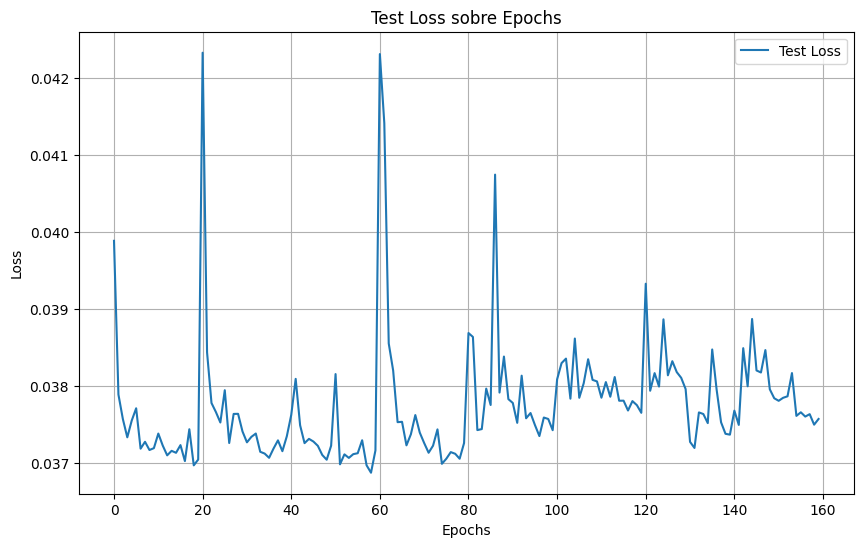

MAE de testeo fue: 0.15930115696044742
RMSE de testeo fue: 0.19251623557571862
MAPE de testeo fue: inf
R2 de testeo fue: 0.04622937023796414


C:\Users\Martin\AppData\Local\Temp\ipykernel_4484\467592512.py:22: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Avoid divide by zero


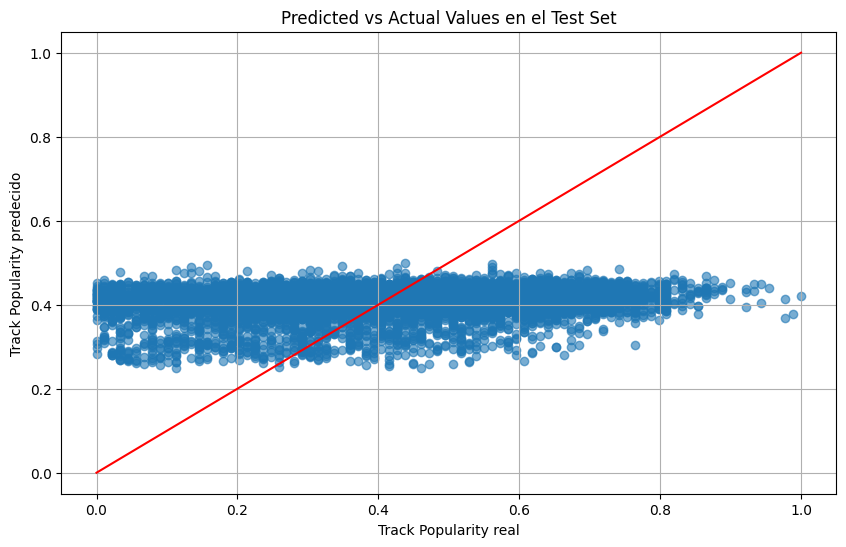

In [41]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


plt.figure(figsize=(10, 6))
plt.plot(test_losses, label="Test Loss")
plt.title("Test Loss sobre Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        y_pred = best_model(X_test_tensor).squeeze().numpy()
        
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
    r2 = r2_score(y_test, y_pred)

    print(f"MAE de testeo fue: {mae}")
    print(f"RMSE de testeo fue: {rmse}")
    print(f"MAPE de testeo fue: {mape}")
    print(f"R2 de testeo fue: {r2}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  
    plt.title("Predicted vs Actual Values en el Test Set")
    plt.xlabel("Track Popularity real")
    plt.ylabel("Track Popularity predecido")
    plt.grid(True)
    plt.show()

In [45]:



if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        y_pred = best_model(X_test_tensor).squeeze().numpy()

    # Calcular metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
    r2 = r2_score(y_test, y_pred)

    print(f"MAE de testeo fue: {mae}")
    print(f"RMSE de testeo fue: {rmse}")
    print(f"MAPE de testeo fue: {mape}")
    print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.15930115696044742
RMSE de testeo fue: 0.19251623557571862
MAPE de testeo fue: inf
R2 de testeo fue: 0.04622937023796414


C:\Users\Martin\AppData\Local\Temp\ipykernel_4484\3167710323.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [22]:

numerical_features_2 = ['acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo']

X = df[numerical_features_2].values
y = df['track_popularity'].values  # Target track_popularity


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
#modelo 2
class MusicNet_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet_2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet_2(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval() 
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss) 
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.5955185890197754
Batch 400, Loss: 0.03399201110005379
Train Loss: 0.0445
Test Loss: 0.0396
Epoch 2
-------------------------------
Batch 0, Loss: 0.04877397418022156
Batch 400, Loss: 0.0460297092795372
Train Loss: 0.0388
Test Loss: 0.0376
Epoch 3
-------------------------------
Batch 0, Loss: 0.03821568191051483
Batch 400, Loss: 0.02633800357580185
Train Loss: 0.0382
Test Loss: 0.0379
Epoch 4
-------------------------------
Batch 0, Loss: 0.02502480335533619
Batch 400, Loss: 0.036039866507053375
Train Loss: 0.0380
Test Loss: 0.0377
Epoch 5
-------------------------------
Batch 0, Loss: 0.03871278092265129
Batch 400, Loss: 0.03497759997844696
Train Loss: 0.0378
Test Loss: 0.0391
Epoch 6
-------------------------------
Batch 0, Loss: 0.03771061822772026
Batch 400, Loss: 0.04992518573999405
Train Loss: 0.0379
Test Loss: 0.0380
Epoch 7
-------------------------------
Batch 0, Loss: 0.04639773443341255
Batch 400, Loss: 0.0338262915611

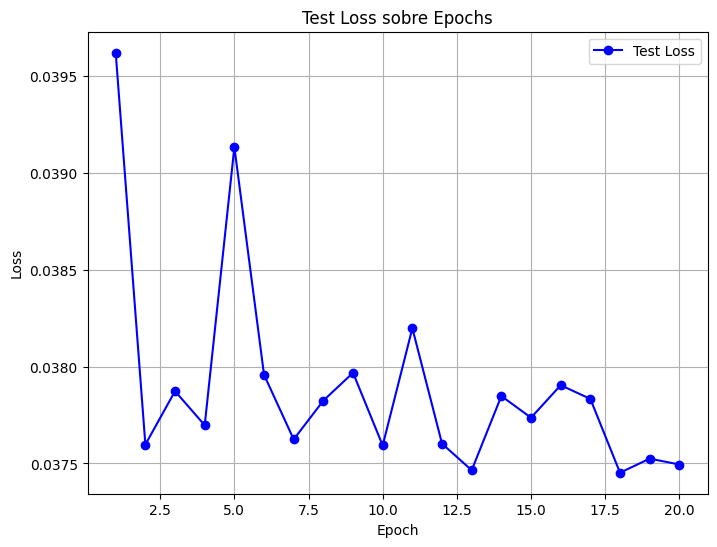

In [24]:
import matplotlib.pyplot as plt


epochs_list = list(range(1, epochs + 1))


plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1936


In [26]:
df_pca = pd.read_csv('df_pca9.csv')

In [27]:
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,track_id,track_popularity
0,-1.228247,-2.007737,0.636795,-1.357469,-1.137151,-1.301107,-0.040412,-0.705792,-0.603308,6f807x0ima9a1j3VPbc7VN,0.617978
1,-0.814656,-1.237786,0.390595,-1.321949,-1.275996,-0.900223,1.379120,0.766448,0.605321,0r7CVbZTWZgbTCYdfa2P31,0.629213
2,-1.380825,-1.835965,0.500640,-1.146859,-1.218530,-1.204166,-0.001245,-0.475784,-0.197209,1z1Hg7Vb0AhHDiEmnDE79l,0.662921
3,-1.276420,-1.840713,1.212820,-0.632802,-1.227607,-0.654282,0.240339,0.151130,-0.227065,75FpbthrwQmzHlBJLuGdC7,0.550562
4,-1.036401,-1.130778,0.537385,-1.468597,-1.034739,-1.504985,-0.175239,-0.388876,0.052818,1e8PAfcKUYoKkxPhrHqw4x,0.651685


In [28]:

numerical_features = ['PC0', 'PC1', 'PC2', 
                      'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

X = df_pca[numerical_features].values
y = df_pca['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Deje este escalado estandar porque mejora los resultados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion a tensores de pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo 1
class MusicNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       

        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval()  
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)  
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.22132988274097443
Batch 400, Loss: 0.03548571467399597
Train Loss: 0.0396
Test Loss: 0.0349
Epoch 2
-------------------------------
Batch 0, Loss: 0.03492544963955879
Batch 400, Loss: 0.03546015918254852
Train Loss: 0.0357
Test Loss: 0.0359
Epoch 3
-------------------------------
Batch 0, Loss: 0.0284055694937706
Batch 400, Loss: 0.039490412920713425
Train Loss: 0.0350
Test Loss: 0.0353
Epoch 4
-------------------------------
Batch 0, Loss: 0.03942538797855377
Batch 400, Loss: 0.03467302769422531
Train Loss: 0.0348
Test Loss: 0.0347
Epoch 5
-------------------------------
Batch 0, Loss: 0.03675679862499237
Batch 400, Loss: 0.04047666862607002
Train Loss: 0.0346
Test Loss: 0.0347
Epoch 6
-------------------------------
Batch 0, Loss: 0.03776826709508896
Batch 400, Loss: 0.026608211919665337
Train Loss: 0.0341


Test Loss: 0.0353
Epoch 7
-------------------------------
Batch 0, Loss: 0.035826779901981354
Batch 400, Loss: 0.02555239014327526
Train Loss: 0.0341
Test Loss: 0.0349
Epoch 8
-------------------------------
Batch 0, Loss: 0.02750983089208603
Batch 400, Loss: 0.04540629684925079
Train Loss: 0.0340
Test Loss: 0.0347
Epoch 9
-------------------------------
Batch 0, Loss: 0.03832690417766571
Batch 400, Loss: 0.03185752034187317
Train Loss: 0.0337
Test Loss: 0.0359
Epoch 10
-------------------------------
Batch 0, Loss: 0.04273354262113571
Batch 400, Loss: 0.03576608747243881
Train Loss: 0.0336
Test Loss: 0.0356
Epoch 11
-------------------------------
Batch 0, Loss: 0.02633540891110897
Batch 400, Loss: 0.03627050295472145
Train Loss: 0.0336
Test Loss: 0.0357
Epoch 12
-------------------------------
Batch 0, Loss: 0.020993944257497787
Batch 400, Loss: 0.030035559087991714
Train Loss: 0.0334
Test Loss: 0.0347
Epoch 13
-------------------------------
Batch 0, Loss: 0.03462568297982216
Batch 

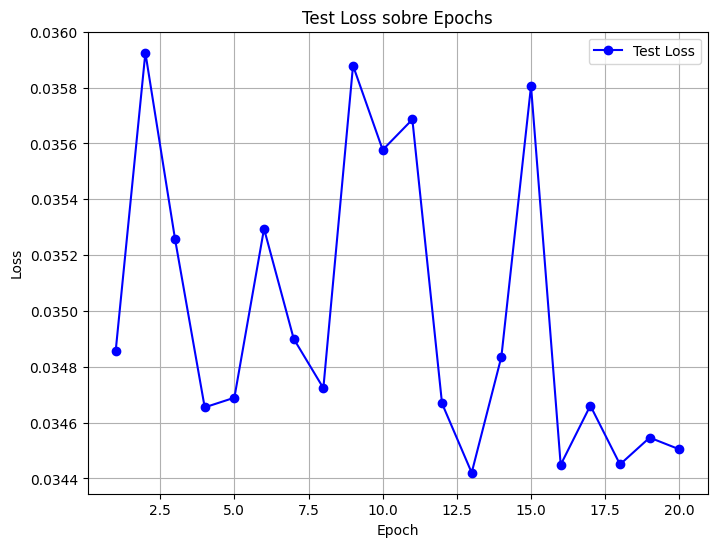

In [29]:
# Plot de los resultados
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:

rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1858
